# Linking Writing Processes to Writing Quality

We need to explore the relationship between learners’ writing behaviors and writing performance, which could provide valuable insights for writing instruction, the development of automated writing evaluation techniques, and intelligent tutoring systems.

## Import libraries

In [1]:
import numpy as np
import pandas as pd
pd.set_option('float_format', '{:.2f}'.format)
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

## Load datasets

In [2]:
WORKDIR = os.getcwd()
train_logs = pd.read_csv(os.path.join(WORKDIR, 'train_logs.csv'))
test_logs = pd.read_csv(os.path.join(WORKDIR, 'test_logs.csv'))
train_scores = pd.read_csv(os.path.join(WORKDIR, 'train_scores.csv'))

### Check  `train_logs` and `test_logs`

| Field Name      | Description                                               |
|-----------------|-----------------------------------------------------------|
| `id`            | The unique ID of the essay                                |
| `event_id`      | The index of the event, ordered chronologically           |
| `down_time`     | The time of the down event in milliseconds                |
| `up_time`       | The time of the up event in milliseconds                  |
| `action_time`   | The duration of the event (up_time - down_time)           |
| `activity`      | The category of activity to which the event belongs       |
| |- `Nonproduction` The event does not alter the text in any way             |
| |- `Input` The event adds text to the essay                                 |
| |- `Remove/Cut` The event removes text from the essay                       |
| |- `Paste` The event changes the text through a paste input                 |
| |- `Replace` The event replaces a section of text with another string       |
| |- `Move` The event moves a section of text spanning character index x1, y1 to a new location x2, y2 |
| `down_event`    | The name of the event when the key/mouse is pressed       |
| `up_event`      | The name of the event when the key/mouse is released      |
| `text_change`   | The text that changed as a result of the event (if any)   |
| `cursor_position` | The character index of the text cursor after the event  |
| `word_count`    | The word count of the essay after the event               |


In [3]:
train_logs.head()

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1


In [4]:
train_logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8405898 entries, 0 to 8405897
Data columns (total 11 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   id               object
 1   event_id         int64 
 2   down_time        int64 
 3   up_time          int64 
 4   action_time      int64 
 5   activity         object
 6   down_event       object
 7   up_event         object
 8   text_change      object
 9   cursor_position  int64 
 10  word_count       int64 
dtypes: int64(6), object(5)
memory usage: 705.5+ MB


In [5]:
test_logs.head()

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,0000aaaa,1,338433,338518,85,Input,Space,Space,,0,0
1,0000aaaa,2,760073,760160,87,Input,Space,Space,,1,0
2,2222bbbb,1,711956,712023,67,Input,q,q,q,0,1
3,2222bbbb,2,290502,290548,46,Input,q,q,q,1,1
4,4444cccc,1,635547,635641,94,Input,Space,Space,,0,0


In [6]:
test_logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               6 non-null      object
 1   event_id         6 non-null      int64 
 2   down_time        6 non-null      int64 
 3   up_time          6 non-null      int64 
 4   action_time      6 non-null      int64 
 5   activity         6 non-null      object
 6   down_event       6 non-null      object
 7   up_event         6 non-null      object
 8   text_change      6 non-null      object
 9   cursor_position  6 non-null      int64 
 10  word_count       6 non-null      int64 
dtypes: int64(6), object(5)
memory usage: 656.0+ bytes


#### Check for missing values and duplicates

In [7]:
train_logs.isna().sum()

id                 0
event_id           0
down_time          0
up_time            0
action_time        0
activity           0
down_event         0
up_event           0
text_change        0
cursor_position    0
word_count         0
dtype: int64

In [8]:
train_logs.duplicated().sum()

0

### Check `train_scores`

| Column   | Description                                   |
| -------- | --------------------------------------------- |
| `id`       | The unique ID of the essay                   |
| `score`    | The score the essay received out of 6 (the prediction target for the competition) |


In [9]:
train_scores.head()

,id,score
0,001519c8,3.50
1,0022f953,3.50
2,0042269b,6.00
3,0059420b,2.00
4,0075873a,4.00


In [10]:
train_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2471 entries, 0 to 2470
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      2471 non-null   object 
 1   score   2471 non-null   float64
dtypes: float64(1), object(1)
memory usage: 38.7+ KB


In [11]:
train_scores.duplicated().sum()

0

## EDA

### `Train_logs`

#### `event_id`

Check events for each unique `id`

In [12]:
train_logs.groupby('id')['event_id'].count().describe()

count    2471.00
mean     3401.82
std      1578.85
min       262.00
25%      2193.50
50%      3082.00
75%      4301.00
max     12876.00
Name: event_id, dtype: float64

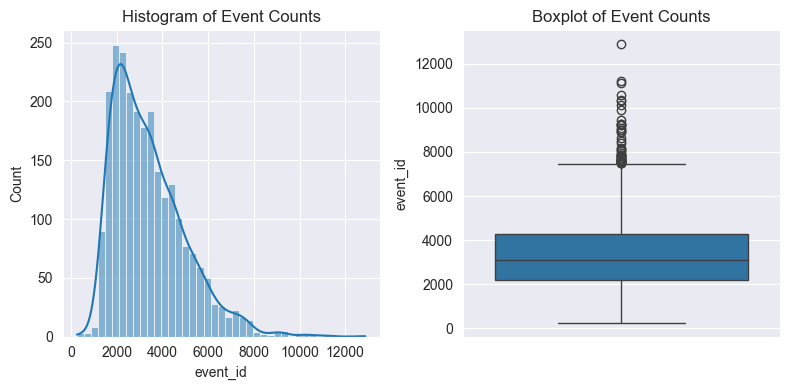

In [13]:
sns.set_style("darkgrid")
fig, (ax_1,ax_2) = plt.subplots(1,2, figsize=(8,4))
sns.histplot(train_logs.groupby('id')['event_id'].count(),kde=True, ax=ax_1);
ax_1.set_title('Histogram of Event Counts')
sns.boxplot(train_logs.groupby('id')['event_id'].count(),ax=ax_2);
ax_2.set_title('Boxplot of Event Counts')
plt.tight_layout();

Check the correlation with the score

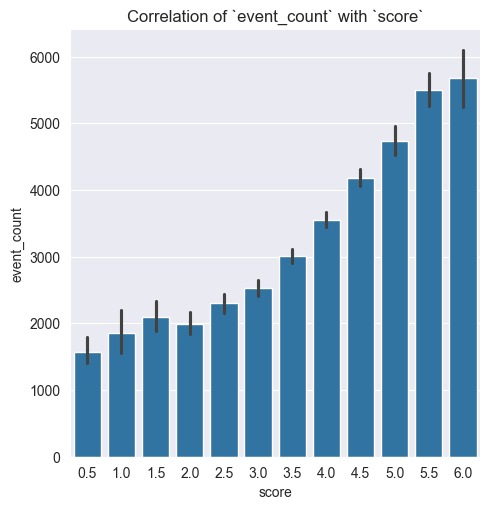

In [14]:
event_count = train_logs.groupby('id')['event_id'].count().reset_index()
event_count.rename(columns={'event_id': 'event_count'}, inplace=True)
catplot = sns.catplot(data=event_count.merge(train_scores,on='id'),x='score',y='event_count',kind='bar');
catplot.set(title='Correlation of `event_count` with `score`');


The correlation is obvious. We will use it as one of the features.

#### `down_time`,	`up_time`,	`action_time`

Check if there are any mistakes in calculation of `action_time`.

In [15]:
train_logs[(train_logs['up_time']-train_logs['down_time']) != train_logs['action_time']]['id'].sum()

0

Check the distribution of `action_time`.

In [16]:
train_logs.groupby('id')['action_time'].mean().describe()

count   2471.00
mean      99.95
std       24.11
min        8.42
25%       83.66
50%       97.02
75%      114.52
max      282.61
Name: action_time, dtype: float64

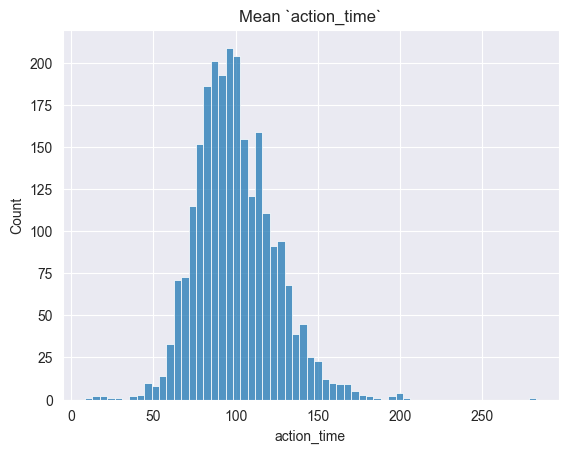

In [17]:
histplot = sns.histplot(train_logs.groupby('id')['action_time'].mean());
histplot.set(title='Mean `action_time`');

Check the distribution of time taken to write the essay.

In [18]:
time_calculation = train_logs.groupby('id')['down_time'].min().reset_index()
max_up_time = train_logs.groupby('id')['up_time'].max().reset_index()
time_calculation = time_calculation.merge(max_up_time, on='id')
time_calculation['time_taken'] = time_calculation['up_time'] - time_calculation['down_time']

In [19]:
time_calculation['time_taken'] = time_calculation['time_taken'].divide(60_000)
time_calculation.describe()

,down_time,up_time,time_taken
count,2471.00,2471.00,2471.00
mean,42393.87,1769537.27,28.79
std,165828.43,276028.25,4.14
min,106.00,229548.00,3.77
25%,2131.50,1754901.00,28.36
50%,21149.00,1792315.00,29.34
75%,45925.00,1807774.50,29.91
max,7452424.00,8313707.00,88.52


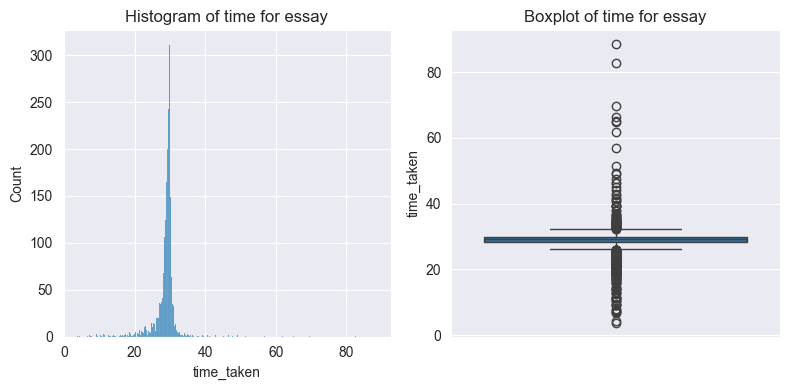

In [20]:
fig, (ax_1,ax_2) = plt.subplots(1,2, figsize=(8,4))
sns.histplot(time_calculation['time_taken'],ax=ax_1)
ax_1.set_title('Histogram of time for essay')
sns.boxplot(time_calculation['time_taken'],ax=ax_2)
ax_2.set_title('Boxplot of time for essay')
plt.tight_layout()

Check the correlation of time taken to write essay with `scores`

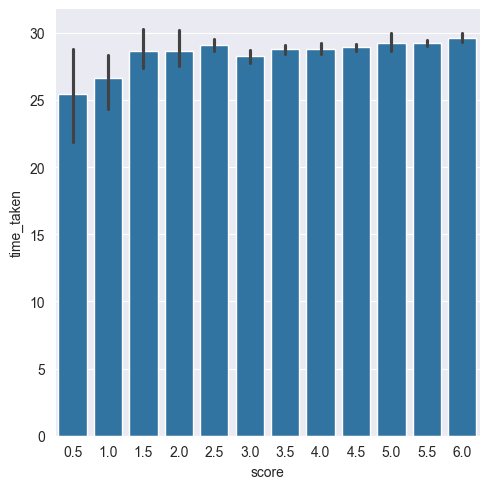

In [21]:
sns.catplot(data=time_calculation.merge(train_scores, on='id'),x='score',y='time_taken',kind='bar')

For scores 1.5 - 6.0 time is not cruical feature.

#### `activity`

In [22]:
train_logs['activity'].unique()

array(['Nonproduction', 'Input', 'Remove/Cut', 'Replace',
       'Move From [284, 292] To [282, 290]',
       'Move From [287, 289] To [285, 287]',
       'Move From [460, 461] To [465, 466]', 'Paste',
       'Move From [905, 1314] To [907, 1316]',
       'Move From [565, 743] To [669, 847]',
       'Move From [669, 847] To [565, 743]',
       'Move From [1041, 1121] To [1496, 1576]',
       'Move From [1455, 1557] To [1323, 1425]',
       'Move From [2268, 2275] To [2247, 2254]',
       'Move From [213, 302] To [902, 991]',
       'Move From [0, 158] To [234, 392]',
       'Move From [460, 465] To [925, 930]',
       'Move From [810, 906] To [816, 912]',
       'Move From [186, 187] To [184, 185]',
       'Move From [140, 272] To [299, 431]',
       'Move From [114, 140] To [272, 298]',
       'Move From [1386, 1450] To [1445, 1509]',
       'Move From [442, 524] To [296, 378]',
       'Move From [408, 414] To [390, 396]',
       'Move From [1144, 1147] To [1142, 1145]',
       'Move 

Check the number of `Move From...` actions

In [23]:
train_logs[train_logs['activity'].str.contains('Move')]['id'].count()

46

46 is not quite a big number. This element won't affect the model much, so we can rename this activity as just `Move`

In [24]:
pattern = r'Move From \[\d+, \d+\] To \[\d+, \d+\]'

move_rows = train_logs['activity'].str.contains(pattern)

train_logs.loc[move_rows, 'activity'] = 'Move'

In [25]:
train_logs['activity'].unique()

array(['Nonproduction', 'Input', 'Remove/Cut', 'Replace', 'Move', 'Paste'],
      dtype=object)

In [26]:
(train_logs['activity'].value_counts() / train_logs['activity'].value_counts().sum()) * 100

activity
Input           80.02
Remove/Cut      11.54
Nonproduction    8.37
Replace          0.05
Paste            0.01
Move             0.00
Name: count, dtype: float64

Classes are imbalanced, so we won't see much useful information about the distribution and correlation with scores.
But anyway, lets check.
Also we can see 3 main classes according to the frequency of actions made:
1) `Input`;
2) `Remove/Cut` and `Nonproduction`;
3) `Replace`, `Paste` and `Move`

Check the distribution

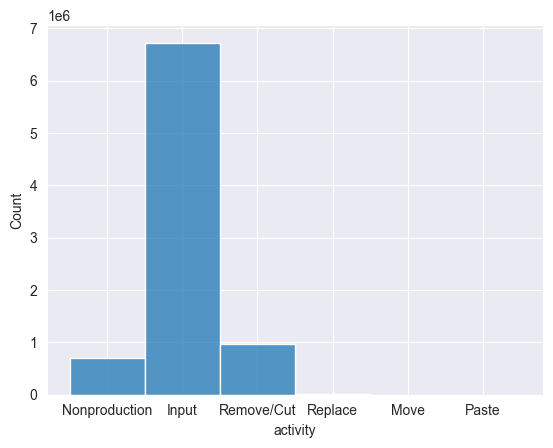

In [27]:
sns.histplot(train_logs,x='activity');

Make a heatmap

In [28]:
activity_count = pd.crosstab(index=train_logs['id'], columns=train_logs['activity'])
activity_count = activity_count.merge(train_scores,on='id')
activity_count.head()

,id,Input,Move,Nonproduction,Paste,Remove/Cut,Replace,score
0,001519c8,2010,3,120,0,417,7,3.50
1,0022f953,1938,0,254,1,260,1,3.50
2,0042269b,3515,0,175,0,439,7,6.00
3,0059420b,1304,0,99,1,151,1,2.00
4,0075873a,1942,0,72,0,517,0,4.00


<Axes: >

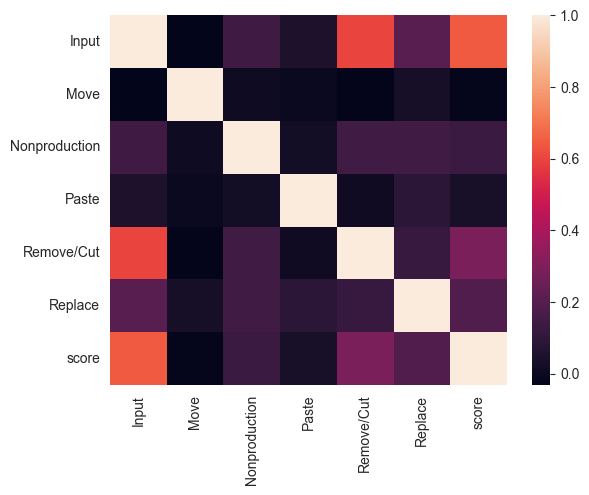

In [29]:
sns.heatmap(activity_count.drop(columns='id').corr())

Unexpected fact: `Replace` being used 0.05% of all the actions is also correlated with `score`.

#### `down_event`,	`up_event`

In [30]:
train_logs['down_event'].unique()

array(['Leftclick', 'Shift', 'q', 'Space', 'Backspace', '.', ',', 'Enter',
       'ArrowLeft', "'", ';', 'ArrowRight', '-', '?', 'Tab', '"',
       'ArrowUp', 'ArrowDown', 'Rightclick', '=', 'CapsLock', 'Control',
       'c', 'v', '/', 'Delete', ':', 'z', '[', '$', '(', ')', '+', 'Home',
       'End', '\\', 'Meta', '*', '&', 'AudioVolumeMute', 'x', '!',
       'Insert', 'MediaPlayPause', 'NumLock', '%', 'V', '>', 'Alt',
       'AudioVolumeUp', 'ContextMenu', 'AudioVolumeDown', 'a', '<',
       'PageDown', ']', 'Middleclick', '@', 'F12', 'j', '\x96', 'Dead',
       't', 's', 'n', 'y', '{', 'ScrollLock', '¿', 'Process', '}',
       'MediaTrackPrevious', 'MediaTrackNext', 'F3', '^', 'Unidentified',
       'Cancel', '2', 'i', 'd', 'r', 'e', '`', '\x9b', 'm', '#', '~',
       'PageUp', 'T', 'A', 'b', 'S', 'ModeChange', '_', 'Escape', 'F11',
       'Unknownclick', 'AltGraph', 'F10', 'h', 'F15', 'Clear', 'OS', 'F',
       'C', 'o', 'Ä±', 'f', 'u', 'w', 'p', 'g', 'M', 'l', '|',
       'â\x80\x

In [31]:
top10_down_event = train_logs['down_event'].value_counts().sort_values(ascending=False).reset_index().head(10)
top10_down_event

,down_event,count
0,q,5365319
1,Space,1207128
2,Backspace,964089
3,Shift,334227
4,ArrowRight,121338
5,Leftclick,91126
6,ArrowLeft,63217
7,.,59586
8,",",46806
9,ArrowDown,30874


In [32]:
train_logs['up_event'].unique()

array(['Leftclick', 'Shift', 'q', 'Space', 'Backspace', '.', ',', 'Enter',
       'ArrowLeft', "'", ';', 'ArrowRight', '-', '?', 'Tab', '"',
       'ArrowUp', 'ArrowDown', 'm', 'Rightclick', 'i', 'o', 't', '=', 'a',
       'CapsLock', 'Control', 'c', 'v', '/', 'Delete', ':', 'z', '[', '$',
       '(', ')', '+', 'Home', 'End', '\\', 'Meta', '*', '&',
       'AudioVolumeMute', 'x', '!', 'Insert', 'MediaPlayPause', 'w',
       'NumLock', '%', 'V', 'b', '>', 'Alt', 'AudioVolumeUp',
       'ContextMenu', 'AudioVolumeDown', 'n', 'e', '<', 'PageDown', ']',
       'Middleclick', '@', 'F12', 'u', 'j', 's', '\x96', 'Dead', 'y', '{',
       'ScrollLock', '¿', 'p', 'Process', '}', 'MediaTrackPrevious',
       'MediaTrackNext', 'F3', '^', 'Unidentified', 'Cancel', 'h', '2',
       'd', 'r', '`', '\x9b', 'f', 'g', '#', '~', 'PageUp', 'l', 'T', 'A',
       'S', 'ModeChange', '_', 'Escape', 'F11', 'Unknownclick',
       'AltGraph', 'F10', 'F15', 'Clear', 'OS', 'C', 'Ä±', 'M', '|',
       'â\x80\x93', 

In [33]:
top10_up_event = train_logs['up_event'].value_counts().sort_values(ascending=False).reset_index().head(10)
top10_up_event

,up_event,count
0,q,5364789
1,Space,1207128
2,Backspace,964089
3,Shift,334227
4,ArrowRight,121338
5,Leftclick,91126
6,ArrowLeft,63217
7,.,59586
8,",",46806
9,ArrowDown,30874


Let's make a list of top_10 events, we may use it later.

In [34]:
top_10_events = top10_down_event['down_event'].to_list()
top_10_events

['q',
 'Space',
 'Backspace',
 'Shift',
 'ArrowRight',
 'Leftclick',
 'ArrowLeft',
 '.',
 ',',
 'ArrowDown']

Make a list of top event for each activity

In [35]:
events_for_activities = {}
for activity in train_logs['activity'].unique():
    activity_data = train_logs[train_logs['activity'] == activity]
    event_counts = activity_data['down_event'].value_counts()
    top_events = event_counts.head(10).index.tolist()
    events_for_activities[activity] = top_events

for key, values in events_for_activities.items():
    print(f'Top 10 events for {key}: {values}')

Top 10 events for Nonproduction: ['Shift', 'ArrowRight', 'Leftclick', 'ArrowLeft', 'ArrowDown', 'ArrowUp', 'CapsLock', 'Unidentified', 'Control', 'Backspace']
Top 10 events for Input: ['q', 'Space', '.', ',', 'Enter', "'", '"', '-', '?', ';']
Top 10 events for Remove/Cut: ['Backspace', 'Delete', 'x', 'z', 'Rightclick']
Top 10 events for Replace: ['q', 'Space', '.', ',', 'z', 'v', 'Enter', 'Rightclick', '"', '-']
Top 10 events for Move: ['Leftclick', 'z']
Top 10 events for Paste: ['v', 'Space', 'Rightclick', 'z', 's', 't', 'r', 'i', 'n', 'e']


#### `text_change`

In [36]:
train_logs.head()

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1


In [37]:
train_logs['text_change'].value_counts(ascending=False).reset_index().head(20)

,text_change,count
0,q,6128208
1,,1376829
2,NoChange,703851
3,.,67797
4,",",54797
5,\n,27977
6,',13192
7,"""",4659
8,-,4492
9,?,3507


In [38]:
list = train_logs['text_change'].unique().tolist()
list

['NoChange',
 'q',
 ' ',
 '.',
 ',',
 ' qqq qqqqq  =>  ',
 'qqqqq qq => q',
 'qqqq  => q',
 '\n',
 "'",
 ';',
 'qqqqqqq ',
 'qq',
 'qqqqqqq qqqqqq  => q',
 'qq qqqqqqqq qqqqq => q',
 'qqqqq  => q',
 'qqqqqqqqq  => q',
 '-',
 '?',
 '"',
 '\n ',
 'qqqqqq => q',
 'qqqqqqq qqq qqqq qqqq qqqq qq qqqqqqqq qqqqqqq  => q',
 'qqqqqqq  => q',
 'qqqqq qqq qqqq qq ',
 'qqq qq qqq qqqqqqq qqqqqq qqqq qq  => q',
 'qqq qqqqq qq qqqqqqqq qqqq qqq qqqqqqq qq qqqqq qqqqq qqqqqq => q',
 'qqqqqqq, qqqq qqqqq qqqqqq qqq qqqq qqqq qqqq qqqq qqqq qqqqqqq qqqq qqq qq qqqqqq qqqq qqqq qqq qqqqqq qqqqqq qq qqq qqq qqqqqqqq qqqqq qqqq qqqq qqq ',
 'qqq qqqqqq qq qqqqq qqqqqq  => q',
 'qqqqqqqqq qqqqq qqqqq qqq qqqqq qq qqqqqqqqqq qqqq qqqqqqq qqqqqqqqq qqqqqqq, q => q',
 '=',
 'qq qq qqqqq qqqq qqqqqqqqq\n',
 'qqqqqqq qqqqqqqqq qqqq qqq qq qqqq qqq qqqqqqqqq => q',
 'qqqqqqqqqqq  => =',
 'qqqqqqqqqqq ',
 '/',
 'qq => q',
 'qqq => q',
 'qqqqq => q',
 'qqqq',
 '\n => q',
 ':',
 'qqqqq qq qq qqqqqqqqq - qq qqq qqqq

In [39]:
before = []
after = []
for i in train_logs['text_change']:
    if '=>' in i:
        parts = i.split('=>')
        before.append(parts[0])
        after.append(parts[1])
    elif i == 'NoChange':
        before.append(' - ')
        after.append(' - ')
    else:
        before.append(' - ')
        after.append(i)

In [40]:
train_logs['before'] = before
train_logs['after'] = after

#### `cursor_position`

In [41]:
train_logs.groupby('id')['cursor_position'].mean().sort_values()

id
5a3f0d07    113.71
8ee8c46c    136.39
95acfe17    184.57
08e3c7ae    189.72
79ee2112    237.89
             ...  
347a3473   3390.06
3b5cd2b2   3408.84
ef7c6ea1   3432.43
2d58eb30   3492.73
4fab5ef9   3734.25
Name: cursor_position, Length: 2471, dtype: float64

<Axes: xlabel='cursor_position', ylabel='Count'>

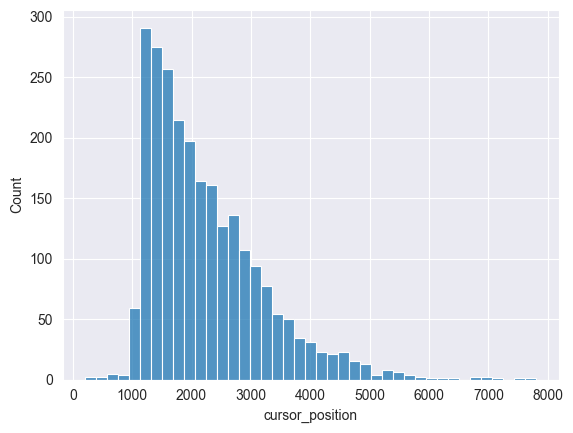

In [42]:
sns.histplot(train_logs.groupby('id')['cursor_position'].max())

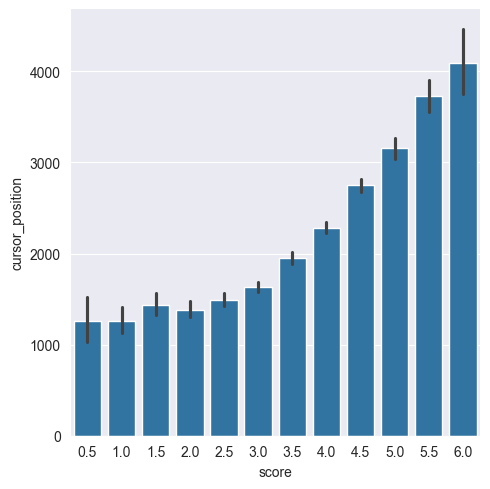

In [43]:
cursor_position = train_logs.groupby('id')['cursor_position'].max().reset_index()
sns.catplot(data=cursor_position.merge(train_scores,on='id'),x='score',y='cursor_position',kind='bar')

We see a correlation

#### `word_count`

In [44]:
train_logs.groupby('id')['word_count'].max().sort_values(ascending=False)

id
1a8cbd7f    1326
4fab5ef9    1296
3b5cd2b2    1247
2d58eb30    1233
2e01a66f    1186
            ... 
23022dee     108
8ee8c46c      73
08e3c7ae      72
95acfe17      67
5a3f0d07      35
Name: word_count, Length: 2471, dtype: int64

<Axes: xlabel='word_count', ylabel='Count'>

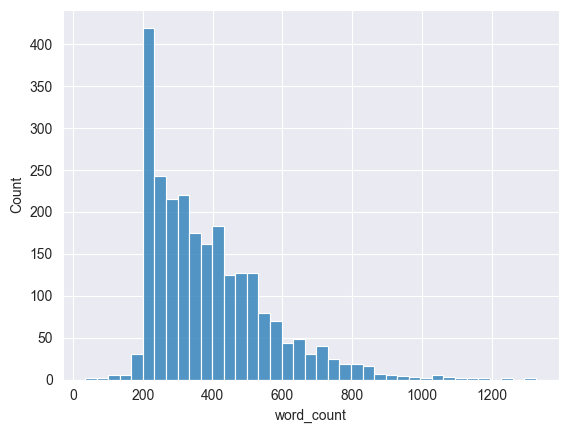

In [45]:
sns.histplot(train_logs.groupby('id')['word_count'].max())

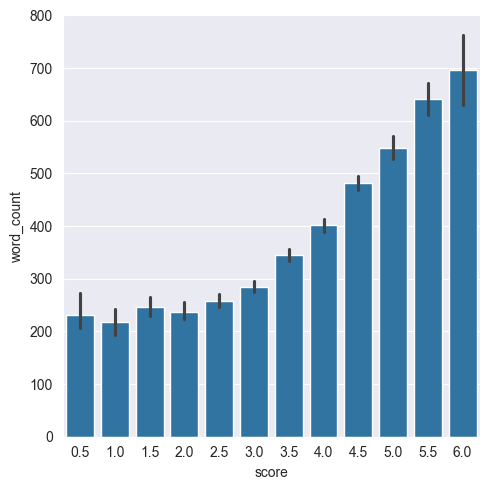

In [46]:
word_count = train_logs.groupby('id')['word_count'].max().reset_index()
sns.catplot(data=word_count.merge(train_scores, on='id'),x='score',y='word_count',kind='bar')

### `Train_scores`

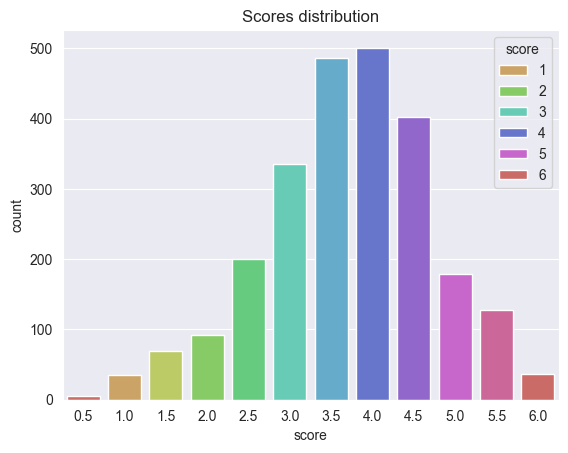

In [47]:
sns.countplot(data=train_scores,x='score', hue='score',palette = "hls").set(title='Scores distribution');

## Feature engineering

### 1. Number of actions for each `id`

In [48]:
def action(df):
    features = df.groupby('id')['event_id'].count().reset_index()
    features.rename(columns={'event_id': 'total_events'}, inplace=True)
    return features

In [49]:
train_features = action(train_logs)
test_features = action(test_logs)

### 2. Total time that has been used for every `id`

In [50]:
def time_total(df, features):
    total_time = df.groupby('id')['up_time'].max().reset_index()
    total_time.rename(columns={'up_time': 'total_time'}, inplace=True)
    features = features.merge(total_time,on='id',how='left')
    return features

In [51]:
train_features = time_total(train_logs,train_features)
test_features = time_total(test_logs,test_features)

### 3. Number of activities.

In [52]:
def count_activities(df, features):
    activities_count = df.groupby(['id', 'activity'])['event_id'].count().reset_index()
    activities_count = pd.pivot_table(index='id', columns='activity', values='event_id', data=activities_count).fillna(0)
    activities_list = train_logs['activity'].unique()
    for i in activities_list:
        if i not in activities_count.columns:
           activities_count[i] = 0 
    features = features.merge(activities_count, on='id', how='left')           
    return features

In [53]:
train_features = count_activities(train_logs,train_features)
test_features = count_activities(test_logs,test_features)
test_features= test_features.reindex(columns=train_features.columns) 

### 4. Number, total and mean time for pauses

In [54]:
def calculation_pause(df, features):
    df['pause_time'] = np.where(
    (df['id'] != df['id'].shift(-1)) | (df['event_id'] == 1),
    0,
    df['down_time'].shift(-1) - df['up_time'].fillna(0))

    df.loc[df['pause_time'] < 2000, 'pause_time'] = 0
    pause_calc = df.groupby(['id'])['pause_time'].agg(
        pause_sum='sum',pause_mean='mean',pause_count='count').reset_index()
    pause_calc['percent_of_pause_time'] = (pause_calc['pause_sum'] / features['total_time']) * 100
    features = features.merge(pause_calc, on='id',how='left')
    return features

In [55]:
train_features = calculation_pause(train_logs,train_features)
test_features = calculation_pause(test_logs,test_features)

### 5. Writing time

In [56]:
def writing_time(df, features):
    total_writing_time = df[df['activity'] != 'Nonproduction'].\
                     groupby('id')['action_time'].sum().reset_index()
    total_writing_time.rename(columns={'action_time': 'total_writing_time'}, inplace=True)
    features = features.merge(total_writing_time,on='id',how='left')
    return features

In [57]:
train_features = writing_time(train_logs,train_features)
test_features = writing_time(test_logs,test_features)

### 6. Revision features

In [58]:
def revisions(df, features):
    # number_of_deletions   
    number_of_deletions = df[(df['activity'] == 'Remove/Cut')].\
    groupby('id')['event_id'].count().reset_index()
    number_of_deletions.rename(columns={'event_id': 'number_of_deletions'}, inplace=True)
    features = features.merge(number_of_deletions, on='id',how='left')
    # number_of_insertions
    number_of_insertions = df[(df['activity'] == 'Input')].\
    groupby('id')['event_id'].count().reset_index()
    number_of_insertions.rename(columns={'event_id': 'number_of_insertions'}, inplace=True)
    features = features.merge(number_of_insertions, on='id',how='left')
    #proportion of deletions (as a % of total writing time)
    features['% of deletions'] =  features['number_of_deletions'] / features['total_time'] * 100
    #proportion of insertions (as a % of total writing time)
    features['% of insertions'] =  features['number_of_insertions'] / features['total_time']* 100
    return features
    
    

In [59]:
train_features = revisions(train_logs,train_features)
test_features = revisions(test_logs,test_features)

### 7. Words per minute

In [60]:
def wpm(df, features):
    handwriting_speed = df.groupby('id').agg({'up_time': 'max', 'word_count': 'max'})
    handwriting_speed['up_time'] = handwriting_speed['up_time'] / 60_000
    handwriting_speed['words_per_minute'] = handwriting_speed.apply(
        lambda row: row['up_time'] / row['word_count'] if row['word_count'] > 0 else 0, axis=1)
    handwriting_speed = handwriting_speed.drop(columns=['up_time','word_count'])
    features = features.merge(handwriting_speed,on='id',how='left')
    return features

In [61]:
train_features = wpm(train_logs,train_features)
test_features = wpm(test_logs,test_features)

In [62]:
train_features = train_features.fillna(0)
test_features = test_features.fillna(0)
train_features = train_features.set_index('id')
test_features = test_features.set_index('id')

In [63]:
test_features.head(1)

,total_events,total_time,Input,Move,Nonproduction,Paste,Remove/Cut,Replace,pause_sum,pause_mean,pause_count,percent_of_pause_time,total_writing_time,number_of_deletions,number_of_insertions,% of deletions,% of insertions,words_per_minute
id,,,,,,,,,,,,,,,,,,
0000aaaa,2,760160,2,0,0,0,0,0,0.00,0.00,2,0.00,172,0.00,2,0.00,0.00,0.00


## Merge scores and features

In [64]:
train_features = train_features.merge(train_scores,on='id')

In [65]:
train_features = train_features.set_index('id')

<Axes: >

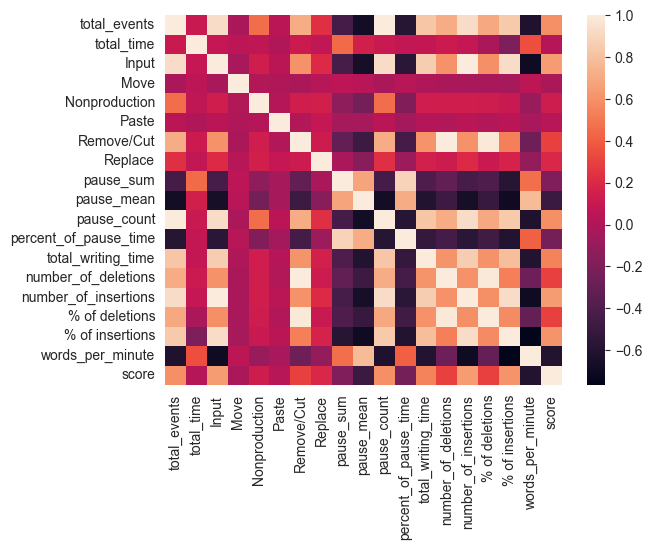

In [66]:
sns.heatmap(train_features.corr())

## Data Preprocessing

Split data for training and validation sets.

In [67]:
features = train_features.drop(columns='score')
target = train_features['score']

In [68]:
features.describe()

,total_events,total_time,Input,Move,Nonproduction,Paste,Remove/Cut,Replace,pause_sum,pause_mean,pause_count,percent_of_pause_time,total_writing_time,number_of_deletions,number_of_insertions,% of deletions,% of insertions,words_per_minute
count,2471.00,2471.00,2471.00,2471.00,2471.00,2471.00,2471.00,2471.00,2471.00,2471.00,2471.00,2471.00,2471.00,2471.00,2471.00,2471.00,2471.00,2471.00
mean,3401.82,1769537.27,2722.30,0.02,284.84,0.24,392.62,1.80,934819.52,355.79,3401.82,52.66,315758.41,392.62,2722.30,0.02,0.16,0.09
std,1578.85,276028.25,1196.38,0.19,503.53,1.20,332.91,3.63,293885.58,256.19,1578.85,13.88,151329.60,332.91,1196.38,0.02,0.07,0.04
min,262.00,229548.00,230.00,0.00,2.00,0.00,0.00,0.00,39637.00,17.18,262.00,3.79,9554.00,0.00,230.00,0.00,0.01,0.02
25%,2193.50,1754901.00,1786.00,0.00,77.00,0.00,166.00,0.00,753425.00,184.60,2193.50,43.05,199432.00,166.00,1786.00,0.01,0.10,0.06
50%,3082.00,1792315.00,2477.00,0.00,132.00,0.00,299.00,0.00,941426.00,300.79,3082.00,53.49,289297.00,299.00,2477.00,0.02,0.14,0.08
75%,4301.00,1807774.50,3397.50,0.00,284.00,0.00,521.50,2.00,1106138.50,472.24,4301.00,62.25,401717.50,521.50,3397.50,0.03,0.19,0.12
max,12876.00,8313707.00,9091.00,4.00,6100.00,37.00,4567.00,42.00,3889407.00,5891.52,12876.00,96.03,1182634.00,4567.00,9091.00,0.24,0.53,0.77


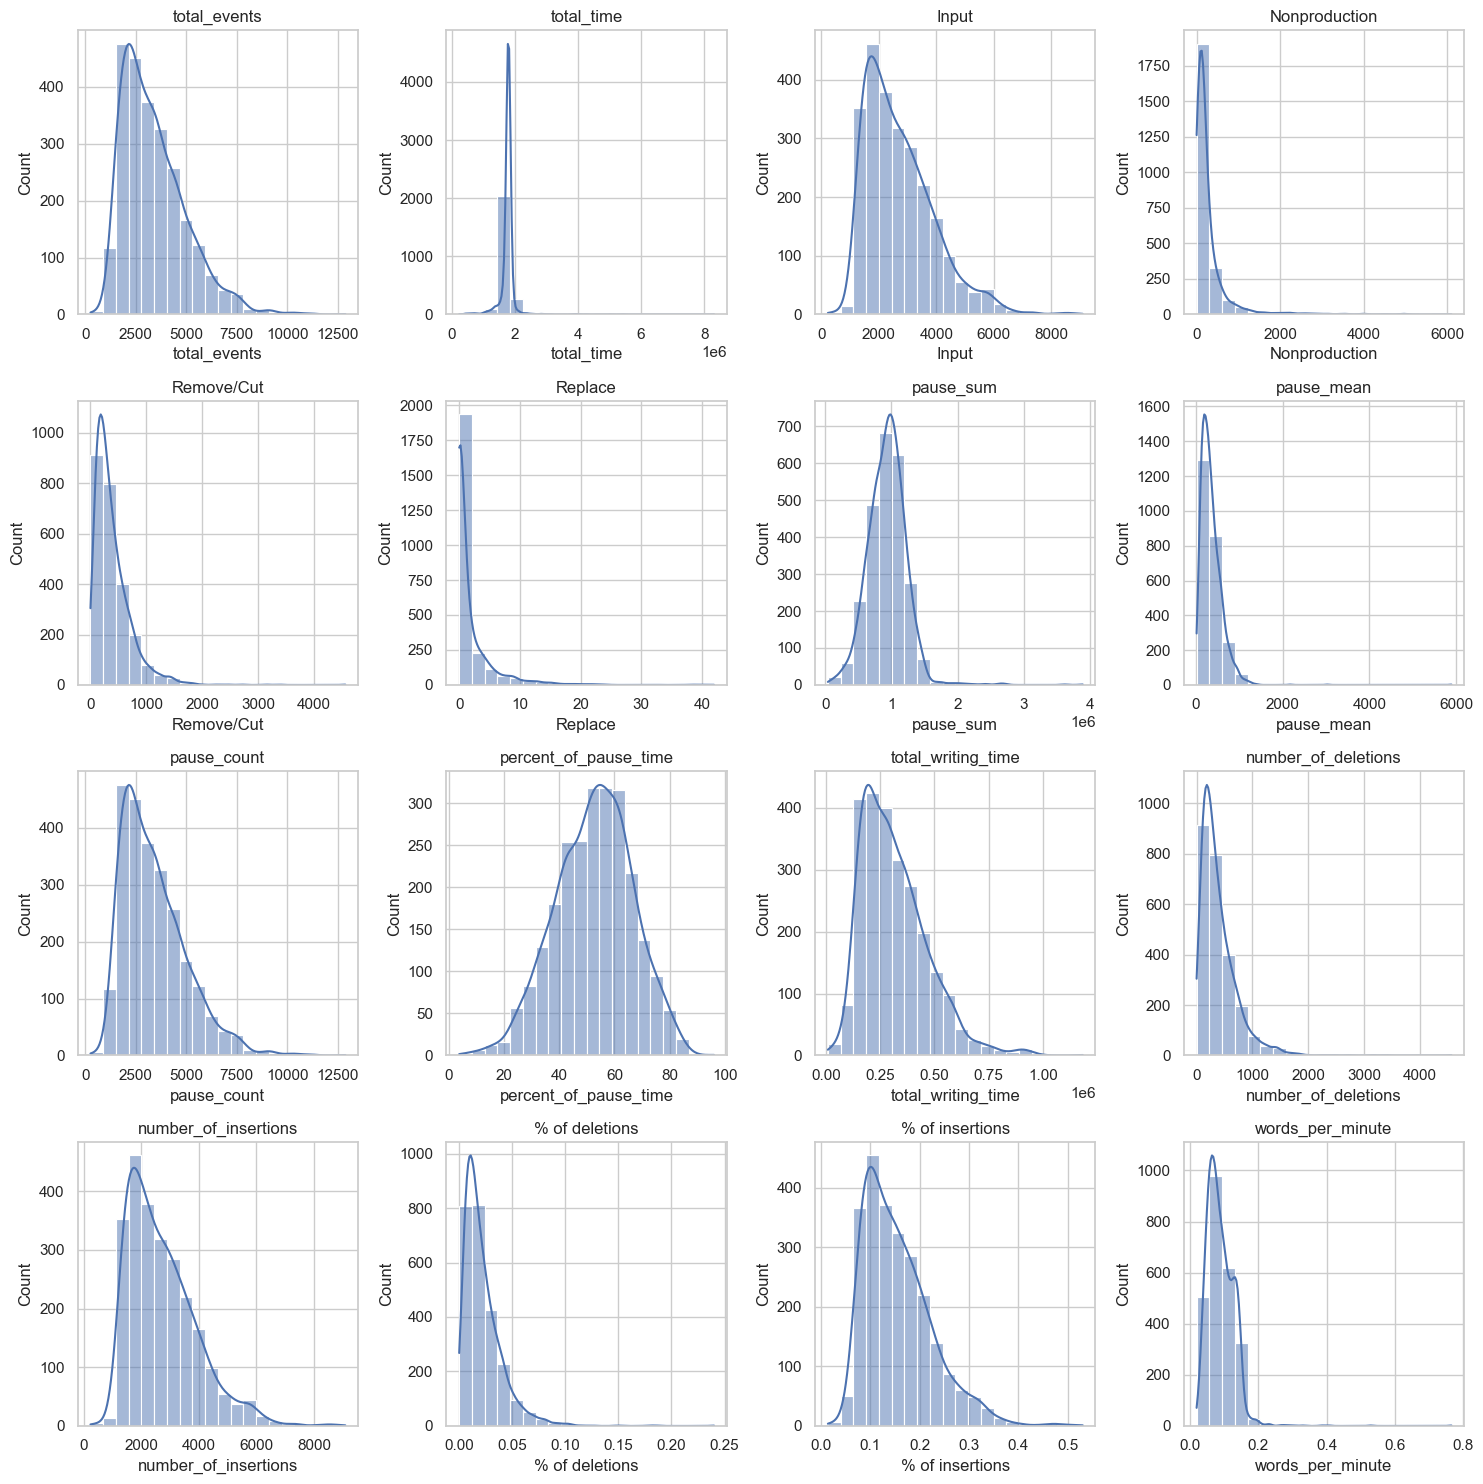

In [69]:
# Selecting features for histograms
cols = ['total_events', 'total_time', 'Input', 'Nonproduction', 'Remove/Cut',
       'Replace', 'pause_sum', 'pause_mean', 'pause_count',
       'percent_of_pause_time', 'total_writing_time', 'number_of_deletions',
       'number_of_insertions', '% of deletions', '% of insertions',
       'words_per_minute']

# Setting the style
sns.set(style="whitegrid")

# Creating subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))
fig.subplots_adjust(hspace=0.5)

# Flatten the axes for ease of plotting
axes = axes.flatten()

# Plot histograms for each feature
for i, feature in enumerate(cols):
    sns.histplot(features[feature], bins=20, ax=axes[i], kde=True)
    axes[i].set_title(feature)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [70]:
X_train, X_val, y_train, y_val = train_test_split(features,target,test_size=0.25,random_state=12345)

Standardize features with `RobustScaler`

In [83]:
transformer = RobustScaler().fit(X_train)

X_train_transformed = transformer.transform(X_train)
X_val_transformed = transformer.transform(X_val)
X_test_transformed = transformer.transform(test_features)

In [84]:
X_train_transformed = pd.DataFrame(X_train_transformed, columns=X_train.columns)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=test_features.columns)

## Prepare models

Make k-Fold cross-validator with 5 splits and prepare scoring metric.

In [73]:
kf = KFold(n_splits=5, shuffle=True)
rms = make_scorer(mean_squared_error, squared=False) 

### Random Forest Regressor

In [77]:
parameters = {
    'max_depth': range (1, 10, 2),
    'n_estimators': range (1, 100, 20)
}

model_rf = RandomForestRegressor()
grid_rf = GridSearchCV(model_rf, parameters, scoring=rms, cv=kf)
grid_rf.fit(X_train_transformed, y_train)
print('Best parameters:{}\nBest score:{}'.format(grid_rf.best_params_, grid_rf.best_score_))

Best parameters:{'max_depth': 9, 'n_estimators': 1}
Best score:0.8836303416302371


### XGBRegressor 

In [78]:
model_xgb = XGBRegressor()
parameters = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.05],
    'n_estimators': [100, 200, 300]
}
grid_xgb = GridSearchCV(model_xgb, parameters, scoring=rms, cv=kf)

grid_xgb.fit(X_train_transformed, y_train)
print('Best parameters:{}\nBest score:{}'.format(grid_xgb.best_params_, grid.best_score_))

Best parameters:{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Best score:0.7623289906883289


## Test prediction

In [86]:
best_params = grid_rf.best_params_
model_rf = RandomForestRegressor(max_depth=best_params['max_depth'], n_estimators=best_params['n_estimators'])

model_rf.fit(X_train_transformed, y_train)

predictions = model_rf.predict(X_test_transformed)


In [88]:
predictions

array([1., 1., 1.])

In [93]:
predicted_df = pd.DataFrame({'id': test_features.index, 'score': predictions})
predicted_df.to_csv('submission.csv', index=False)